In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

from sklearn.ensemble import RandomForestRegressor

In [2]:
rd2 = pd.read_csv('condensed_rd2.csv')
rd3 = pd.read_csv('condensed_rd3.csv')

In [3]:
rd2.head()

,childid,zwfa,zhfa,zbfa,caredu,wi_new,hq_new,sv_new,cd_new,drwaterq_new,toiletq_new,elecq_new,cookingq_new,levlread,levlwrit,z_ppvt,shenv1,shecon1,shecon3
0,ET010001,-1.60,-0.78,-1.77,8,0.751852,0.555556,1.00,0.7,1,1,1,1,,,0.126715,0,0,0
1,ET010002,-2.42,-2.24,-1.46,8,0.494444,0.333333,0.75,0.4,1,1,1,0,,,0.207348,0,1,0
2,ET010004,-1.00,-1.91,0.41,10,0.565873,0.547619,0.75,0.4,1,0,1,1,,,-0.115184,0,0,0
3,ET010005,-1.40,-1.31,-0.82,0,0.361111,0.283333,0.50,0.3,1,0,1,0,,,0.126715,0,0,0
4,ET010006,-1.29,-0.57,-1.45,11,0.495679,0.287037,0.50,0.7,0,0,1,1,,,-0.034551,0,0,0


In [4]:
# First try implementing for Round 2 for livestock shock

In [5]:
rd2 = rd2.set_index('childid')

In [6]:
rd3 = rd3.set_index('childid')

In [7]:
covariates2 = rd2.iloc[:, :12]
treatment2 = rd2['shecon3']
outcome2 = rd2['z_ppvt']

## Multivariate Regression with Shock: Death of Livestock

$ \textbf{Baseline: Linear Model} $

In [8]:
X2 = rd2.iloc[:, :12].drop(['wi_new', 'sv_new'], axis=1)
X2['shecon3'] = rd2['shecon3']
X2.head()

,zwfa,zhfa,zbfa,caredu,hq_new,cd_new,drwaterq_new,toiletq_new,elecq_new,cookingq_new,shecon3
childid,,,,,,,,,,,
ET010001,-1.60,-0.78,-1.77,8,0.555556,0.7,1,1,1,1,0
ET010002,-2.42,-2.24,-1.46,8,0.333333,0.4,1,1,1,0,0
ET010004,-1.00,-1.91,0.41,10,0.547619,0.4,1,0,1,1,0
ET010005,-1.40,-1.31,-0.82,0,0.283333,0.3,1,0,1,0,0
ET010006,-1.29,-0.57,-1.45,11,0.287037,0.7,0,0,1,1,0


In [9]:
# Fit a linear model for round 2
X2_train, X2_test, y2_train, y2_test = train_test_split(X2, outcome2, test_size=0.15)
model2 = LinearRegression()
model2.fit(X2_train, y2_train)
model2.score(X2_test, y2_test)

0.28748237615188765

In [10]:
# Examine coefficients of model for round 2
coef_2 = pd.DataFrame(model2.coef_)
coef_2.index = X2.columns
coef_2.rename(columns={0:'Rd 2 Coefficients'})

,Rd 2 Coefficients
zwfa,0.437831
zhfa,-0.236593
zbfa,-0.267323
caredu,0.006525
hq_new,0.261804
cd_new,0.971405
drwaterq_new,-0.017787
toiletq_new,0.083358
elecq_new,0.318068
cookingq_new,0.347105


In [11]:
# Fit a linear model for round 3
X3 = rd3.iloc[:, :12].drop('wi_new', axis=1)
X3['shecon3'] = rd3['shecon3']
outcome3 = rd3['z_ppvt']

X3_train, X3_test, y3_train, y3_test = train_test_split(X3, outcome3, test_size=0.15)
model3 = LinearRegression()
model3.fit(X3_train, y3_train)
model3.score(X3_test, y3_test)

0.3409342126471556

In [12]:
# Examine coefficients of model for round 3
coef_3 = pd.DataFrame(model3.coef_)
coef_3.index = X3.columns
coef_3 = coef_3.rename(columns={0:'Rd 3 Coefficients'})
coef_3

,Rd 3 Coefficients
zwfa,0.461547
zhfa,-0.223060
zbfa,-0.267108
caredu,-0.001320
hq_new,0.567682
sv_new,0.202591
cd_new,0.967076
drwaterq_new,-0.100791
toiletq_new,0.110344
elecq_new,0.276737


In [13]:
print('Average Treatment Effect: ', coef_3.loc['shecon3', 'Rd 3 Coefficients'])

Average Treatment Effect:  -0.18547037662990945


## Rubin Causal Model / Potential Outcomes Framework

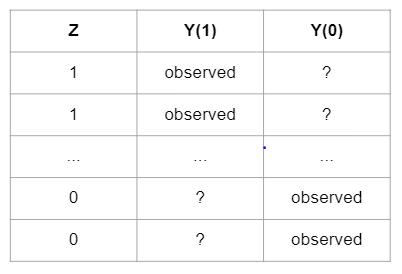

In [14]:
# Separate round 2 data into treated and untreated
rd2_rbc = X2.merge(outcome2, left_index=True, right_index=True)
treated_rbc = rd2_rbc[rd2_rbc['shecon3'] == 1]
untreated_rbc = rd2_rbc[rd2_rbc['shecon3'] == 0]
untreated_rbc['z_ppvt']

childid
ET010001    0.126715
ET010002    0.207348
ET010004   -0.115184
ET010005    0.126715
ET010006   -0.034551
              ...   
ET200094   -0.195817
ET200095   -0.034551
ET200096   -0.840882
ET200098   -0.115184
ET200099   -0.921515
Name: z_ppvt, Length: 1384, dtype: float64

In [15]:
# Fit linear model that predicts outcome based on covariates for untreated group
X_rbc_train, X_rbc_test, y_rbc_train, y_rbc_test = train_test_split(untreated_rbc.iloc[:, :-1], untreated_rbc['z_ppvt'], test_size=0.15)
model_rbc = LinearRegression()
model_rbc.fit(X_rbc_train, y_rbc_train)
model_rbc.score(X_rbc_test, y_rbc_test)

0.15730800180253746

In [16]:
# Use fitted linear model to predict potential outcomes for treated group
predicted_y_rbc = model_rbc.predict(treated_rbc.iloc[:, :-1])

In [17]:
treated_rbc['pred_z_ppvt'] = predicted_y_rbc
treated_rbc['pred_shock_effect'] = treated_rbc['z_ppvt'] - treated_rbc['pred_z_ppvt'] 
treated_rbc

C:\Users\tanvi\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
C:\Users\tanvi\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,zwfa,zhfa,zbfa,caredu,hq_new,cd_new,drwaterq_new,toiletq_new,elecq_new,cookingq_new,shecon3,z_ppvt,pred_z_ppvt,pred_shock_effect
childid,,,,,,,,,,,,,,
ET020025,-0.34,0.25,-0.77,0,0.305556,0.4,1,1,1,0,1,3.110139,0.399291,2.710848
ET020076,-1.38,-1.85,-0.25,28,0.305556,0.2,1,0,1,1,1,-0.518349,0.742327,-1.260676
ET040006,-2.36,-1.92,-1.68,0,0.305556,0.2,1,0,0,0,1,-0.840882,-0.231466,-0.609415
ET040013,-1.09,-1.51,-0.16,0,0.277778,0.2,1,1,1,0,1,-0.518349,0.152127,-0.670476
ET040037,-1.62,-1.30,-1.25,0,0.583333,0.3,1,0,0,0,1,0.207348,0.012881,0.194468
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ET200083,-1.33,-1.47,-0.55,0,0.291667,0.0,0,1,0,0,1,-0.518349,-0.393648,-0.124702
ET200087,-2.50,-0.55,-3.33,0,0.312500,0.0,0,1,0,0,1,0.126715,-0.321167,0.447883
ET200089,-0.70,-0.57,-0.57,0,0.291667,0.0,0,0,0,0,1,-1.324680,-0.352078,-0.972602


In [18]:
treated_rbc.iloc[:, -3:].rename(columns={'z_ppvt': 'Y(1)', 'pred_z_ppvt': 'Y(0)', 
                                         'pred_shock_effect': 'Estimated Treatment Effect'}).sort_values("Estimated Treatment Effect")

,Y(1),Y(0),Estimated Treatment Effect
childid,,,
ET080088,-1.485946,0.113314,-1.599260
ET080006,-0.921515,0.611156,-1.532671
ET090062,-1.163414,0.172176,-1.335590
ET130092,-0.760248,0.571661,-1.331909
ET120032,-1.244047,0.064777,-1.308824
...,...,...,...
ET120066,1.336211,-0.284755,1.620967
ET090075,1.497478,-0.245394,1.742871
ET170040,1.336211,-0.569370,1.905582


In [19]:
# Calculate Average Treatment Effect based on predicted potential outcomes
print('Average Treatment Effect for Treated: ', np.mean(treated_rbc['pred_shock_effect']))

Average Treatment Effect for Treated:  -0.12214842392701254


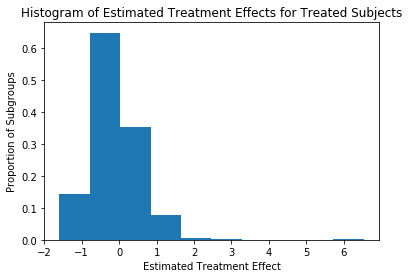

In [20]:
plt.hist(treated_rbc['pred_shock_effect'], density=True)
plt.title("Histogram of Estimated Treatment Effects for Treated Subjects")
plt.xlabel("Estimated Treatment Effect")
plt.ylabel("Proportion of Subgroups")
plt.show()

## Propensity Score Matching

In [21]:
# Try implementing propensity score matching to isolate treatment effect
from sklearn.linear_model import LogisticRegression

In [22]:
# Fit a logisitic regression model to estimate propensity score
log_model = LogisticRegression(solver='lbfgs', max_iter=500)
log_model.fit(X2.drop('shecon3', axis=1), X2['shecon3'])

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=500,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [23]:
prop_scores = log_model.predict_proba(X2.drop('shecon3', axis=1))
prop_scores

array([[0.97904099, 0.02095901],
       [0.86309733, 0.13690267],
       [0.98673975, 0.01326025],
       ...,
       [0.66367553, 0.33632447],
       [0.58170932, 0.41829068],
       [0.75146502, 0.24853498]])

In [24]:
all_rd2 = X2.merge(outcome2, left_index=True, right_index=True)
all_rd2['propensity'] = prop_scores[:, 1]
all_rd2.head()

,zwfa,zhfa,zbfa,caredu,hq_new,cd_new,drwaterq_new,toiletq_new,elecq_new,cookingq_new,shecon3,z_ppvt,propensity
childid,,,,,,,,,,,,,
ET010001,-1.60,-0.78,-1.77,8,0.555556,0.7,1,1,1,1,0,0.126715,0.020959
ET010002,-2.42,-2.24,-1.46,8,0.333333,0.4,1,1,1,0,0,0.207348,0.136903
ET010004,-1.00,-1.91,0.41,10,0.547619,0.4,1,0,1,1,0,-0.115184,0.013260
ET010005,-1.40,-1.31,-0.82,0,0.283333,0.3,1,0,1,0,0,0.126715,0.123098
ET010006,-1.29,-0.57,-1.45,11,0.287037,0.7,0,0,1,1,0,-0.034551,0.020012


In [25]:
# Split data into treated and untreated groups
treated2 = all_rd2[all_rd2['shecon3'] == 1]
untreated2 = all_rd2[all_rd2['shecon3'] == 0]
untreated2.head()

,zwfa,zhfa,zbfa,caredu,hq_new,cd_new,drwaterq_new,toiletq_new,elecq_new,cookingq_new,shecon3,z_ppvt,propensity
childid,,,,,,,,,,,,,
ET010001,-1.60,-0.78,-1.77,8,0.555556,0.7,1,1,1,1,0,0.126715,0.020959
ET010002,-2.42,-2.24,-1.46,8,0.333333,0.4,1,1,1,0,0,0.207348,0.136903
ET010004,-1.00,-1.91,0.41,10,0.547619,0.4,1,0,1,1,0,-0.115184,0.013260
ET010005,-1.40,-1.31,-0.82,0,0.283333,0.3,1,0,1,0,0,0.126715,0.123098
ET010006,-1.29,-0.57,-1.45,11,0.287037,0.7,0,0,1,1,0,-0.034551,0.020012


In [26]:
# Match each subject in the treated group with a subject in the untreated group based on propensity score
att_data = pd.DataFrame(columns=['treated_id', 'treated_prop', 'untreated_id', 'untreated_prop', 'treatment_effect'])
for childid in treated2.index:
    prop = treated2['propensity'][childid]
    differences = np.abs(untreated2['propensity'] - prop)
    matched_sample = np.argmin(differences)
    treatment_effect = treated2['z_ppvt'][childid] - untreated2['z_ppvt'][matched_sample]
    
    child_data = pd.DataFrame({'treated_id': [childid], 'treated_prop': [prop],
                               'untreated_id': [matched_sample], 'untreated_prop': [untreated2['propensity'][matched_sample]],
                               'treatment_effect':[treatment_effect]})
    att_data = att_data.append(child_data)
    untreated2.drop(matched_sample, axis=0)
    

C:\Users\tanvi\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:56: FutureWarning: 
The current behaviour of 'Series.argmin' is deprecated, use 'idxmin'
instead.
The behavior of 'argmin' will be corrected to return the positional
minimum in the future. For now, use 'series.values.argmin' or
'np.argmin(np.array(values))' to get the position of the minimum
row.
  return getattr(obj, method)(*args, **kwds)


In [27]:
att_data.head()

,treated_id,treated_prop,untreated_id,untreated_prop,treatment_effect
0,ET020025,0.131217,ET100093,0.131210,3.870388
0,ET020076,0.014146,ET030100,0.014232,-1.451395
0,ET040006,0.380285,ET070004,0.380213,-1.209496
0,ET040013,0.133035,ET140058,0.133026,-1.370762
0,ET040037,0.299147,ET200005,0.299125,0.806331


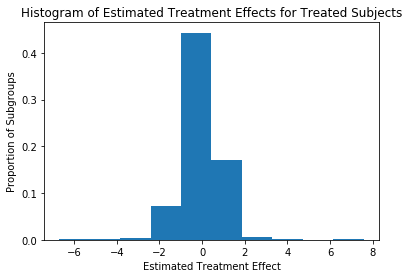

In [28]:
# Plot distribution of estimated treatment effects
plt.hist(att_data['treatment_effect'], density=True)
plt.title("Histogram of Estimated Treatment Effects for Treated Subjects")
plt.xlabel("Estimated Treatment Effect")
plt.ylabel("Proportion of Subgroups")
plt.show()

In [29]:
print('Average Treatment Effect for Treated: ', np.mean(att_data['treatment_effect']))

Average Treatment Effect for Treated:  -0.051835547886195155


In [30]:
# Calculate Standardized Mean Difference for each covariate pre-matching
smds = {}
for column in treated2.columns[:-3]:
    smd = np.abs((np.mean(untreated2[column]) - np.mean(treated2[column])))/ (((np.var(untreated2[column]) + np.var(treated2[column]))/2)**0.5)
    smds[column] = smd

In [31]:
d = pd.DataFrame()
d['SMD'] = smds.values()
d.index = smds.keys()
d['Acceptable?'] = ['Yes' if x < 0.25 else 'No' for x in d['SMD'] ]
d

,SMD,Acceptable?
zwfa,0.218974,Yes
zhfa,0.209451,Yes
zbfa,0.071193,Yes
caredu,0.207248,Yes
hq_new,0.634183,No
cd_new,0.518458,No
drwaterq_new,0.256740,No
toiletq_new,0.197625,Yes
elecq_new,0.838256,No
cookingq_new,0.483533,No


In [32]:
new_untreated = untreated2.merge(pd.DataFrame(att_data['untreated_id']), left_index=True, 
                 right_on='untreated_id').set_index('untreated_id', drop=True)

In [33]:
# Calculate Standardized Mean Difference for each covariate post-matching
smds = {}
for column in treated2.columns[:-3]:
    smd = np.abs((np.mean(new_untreated[column]) - np.mean(treated2[column])))/ (((np.var(new_untreated[column]) + np.var(treated2[column]))/2)**0.5)
    smds[column] = smd

In [34]:
d = pd.DataFrame()
d['SMD'] = smds.values()
d.index = smds.keys()
d.index = smds.keys()
d['Acceptable?'] = ['Yes' if x < 0.25 else 'No' for x in d['SMD'] ]
d

,SMD,Acceptable?
zwfa,0.008394,Yes
zhfa,0.002446,Yes
zbfa,0.003732,Yes
caredu,0.062176,Yes
hq_new,0.023656,Yes
cd_new,0.089434,Yes
drwaterq_new,0.034649,Yes
toiletq_new,0.008672,Yes
elecq_new,0.005951,Yes
cookingq_new,0.000000,Yes
